## Импорты, подключение библиотек

Install Ultralytics for YOLOV8 import

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 290.7 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

Import YOLOv8

In [ ]:
import ultralytics
ultralytics.__version__

'8.2.75'

In [ ]:
from ultralytics import YOLO

model=YOLO('yolov8s.pt') # s - small model

100%|██████████| 21.5M/21.5M [00:00<00:00, 252MB/s]


Main imports

In [ ]:
import pandas as pd
import torch
import cv2
import os
import shutil

GPU support

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

model.to(device)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
device

'cuda'

Главный путь к датасету (изменить при необходимости)

In [ ]:
PATH = '/content/drive/MyDrive/yolo_dataset/images/'

Подключение гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_of_all_files = os.listdir(PATH)
len(list_of_all_files)

648

Открытие файла с метками и bbox'ами в pd.dataframe

In [ ]:
table = pd.read_csv(PATH + 'labels.csv')
table.info()
table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


## Создание датасета для обучения и валидации
Пропустите эти ячейки, если датасеты готовы

Создаем папку с train dataset

In [ ]:
os.mkdir(PATH + 'train/')

На картинке может быть более одного автомобиля

In [ ]:
table.image.value_counts()

,count
image,
vid_4_26460.jpg,7
vid_4_6240.jpg,6
vid_4_26420.jpg,5
vid_4_26380.jpg,5
vid_4_26400.jpg,5
...,...
vid_4_8720.jpg,1
vid_4_8740.jpg,1
vid_4_880.jpg,1


Добавляем для нашей таблицы еще один признак - количество машин.
Полезно для следующих функций для отображения bbox'ов из тренировочной выборки

In [ ]:
new_table = table.copy()

In [ ]:
new_table['num_cars'] = table.image.apply(lambda x: table.image.value_counts().to_dict()[x])

In [ ]:
new_table.sort_values(axis=0, by='num_cars', ascending=False).head(10)

,image,xmin,ymin,xmax,ymax,num_cars
340,vid_4_26460.jpg,364.413893,181.655405,454.416787,219.802124,7
341,vid_4_26460.jpg,473.493488,185.567889,573.279305,227.138031,7
342,vid_4_26460.jpg,563.496382,177.253861,652.520984,213.933398,7
336,vid_4_26460.jpg,0.000000,194.860039,42.555716,232.517696,7
337,vid_4_26460.jpg,34.729378,191.436615,84.622287,226.648970,7
338,vid_4_26460.jpg,179.516642,202.685006,252.888567,230.561454,7
339,vid_4_26460.jpg,197.125904,192.903797,319.901592,233.984878,7
428,vid_4_6240.jpg,178.538350,196.816281,270.986975,227.627091,6
427,vid_4_6240.jpg,39.620839,195.838160,112.014472,227.627091,6
429,vid_4_6240.jpg,393.273517,188.013192,510.668596,233.281853,6


In [ ]:
table = new_table.copy()

Создаем train выборку

In [ ]:
for file in list_of_all_files:
  if file in table.image.unique():
    shutil.move(PATH + file, PATH + 'train/' + file)
print(len(os.listdir(PATH)), len(os.listdir(PATH + 'train/')))

648 355


Создаем файлы с метками и координатами bboxes (labels)

In [ ]:
# Переводим наши координаты граничных точек в координаты центра bbox'а
# и его ширину и высоту, отнормированные на размеры картинки
for file in os.listdir(PATH + 'train/'):
  # (image, xmin, ymin, xmax, ymax)->(class, xmin, xmax, w, h)
  subtable = table[table['image'] == file].copy()
  subtable['image'] = 2    # метка класса 'car'
  subtable.drop(axis=1, columns='num_cars', inplace=True)
  maxW, maxH = 676, 380
  xmax, xmin, ymax, ymin = subtable['xmax'], subtable['xmin'], subtable['ymax'], subtable['ymin']
  subtable['xmin'] = (xmax + xmin) / 2. / maxW
  subtable['ymin'] = (ymax + ymin) / 2. / maxH
  subtable['xmax'] = (xmax - xmin) / maxW
  subtable['ymax'] = (ymax - ymin) / maxH
  subtable.to_csv('/content/drive/MyDrive/yolo_dataset/labels/train/' + file[:-4] + '.txt', header=None, index=None, sep=' ')
# print(len(os.listdir(PATH)), len(os.listdir(PATH + 'train/')))

## Вспомогательные функции
Функции для отображения bbox'ов из обучающей выборки, для предикта YOLO модели

In [ ]:
def show_img_and_bboxes(table, i):
  """
      Функция для отображения картинки и объекта из трен. датасета.
      На вход принимает pd.DataFrame, и номер индекса объекта из таблицы.
      По индексу из таблицы также определяет, сколько машин на картинке,
      и отображает все возможные bbox'ы.
      :return:
        cv2.Image img - результирующая картинка со всеми объектами
  """
  image_name = table.iloc[i].image
  img = cv2.imread(filename=PATH + 'train/' + image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  subtable = table[table['image'] == image_name]
  print(subtable)
  for index, car in subtable.iterrows():
    bbox = cv2.rectangle(img, (int(car.xmin), int(car.ymin)), (int(car.xmax), int(car.ymax)), color=(255,0,0))
  return img

In [ ]:
def show_img_and_bboxes_by_name(table, image_name):
  """
      Функция для отображения картинки и объекта из трен. датасета.
      На вход принимает pd.DataFrame, и название файла картинки из датасета.
      По этому имени также определяет, сколько машин на картинке,
      и отображает все возможные bbox'ы.
      :return:
        cv2.Image img - результирующая картинка со всеми объектами
  """
  img = cv2.imread(filename=PATH + 'train/' + image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  subtable = table[table['image'] == image_name]
  print(subtable)
  for index, car in subtable.iterrows():
    bbox = cv2.rectangle(img, (int(car.xmin), int(car.ymin)), (int(car.xmax), int(car.ymax)), color=(255,0,0))
  return img

Пример использования функций

               image        xmin        ymin        xmax        ymax  num_cars
332  vid_4_26500.jpg    0.000000  200.239704   61.632417  231.539575         4
333  vid_4_26500.jpg  146.254703  197.305341  216.202605  229.094273         4
334  vid_4_26500.jpg  202.506512  199.261583  297.400868  237.408301         4
335  vid_4_26500.jpg  359.033285  183.611647  446.590449  228.605212         4


array([[[ 82, 149, 228],
        [ 82, 149, 228],
        [ 82, 149, 228],
        ...,
        [ 69, 135, 219],
        [ 68, 134, 218],
        [ 67, 133, 217]],

       [[ 84, 151, 230],
        [ 84, 151, 230],
        [ 83, 150, 229],
        ...,
        [ 70, 136, 220],
        [ 70, 136, 220],
        [ 70, 136, 220]],

       [[ 84, 151, 230],
        [ 84, 151, 230],
        [ 83, 150, 229],
        ...,
        [ 71, 137, 221],
        [ 71, 137, 221],
        [ 71, 137, 221]],

       ...,

       [[ 11,  20,  35],
        [ 11,  20,  35],
        [ 11,  20,  35],
        ...,
        [  6,  18,  34],
        [  7,  19,  35],
        [  7,  19,  35]],

       [[  8,  20,  34],
        [  8,  20,  34],
        [ 10,  19,  34],
        ...,
        [  6,  18,  34],
        [  6,  18,  34],
        [  6,  18,  34]],

       [[  7,  19,  33],
        [  7,  19,  33],
        [ 10,  19,  34],
        ...,
        [  7,  19,  35],
        [  6,  18,  34],
        [  6,  18,  34]]], dtype=uint8)
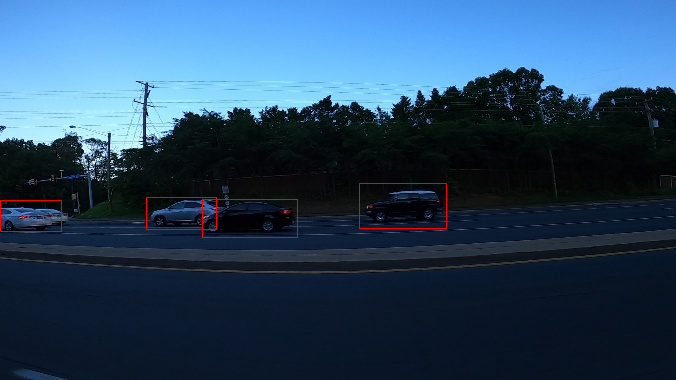

In [ ]:
show_img_and_bboxes(table, 332) # vid_4_26460.jpg - 7 cars

               image        xmin        ymin        xmax        ymax  num_cars
336  vid_4_26460.jpg    0.000000  194.860039   42.555716  232.517696         7
337  vid_4_26460.jpg   34.729378  191.436615   84.622287  226.648970         7
338  vid_4_26460.jpg  179.516642  202.685006  252.888567  230.561454         7
339  vid_4_26460.jpg  197.125904  192.903797  319.901592  233.984878         7
340  vid_4_26460.jpg  364.413893  181.655405  454.416787  219.802124         7
341  vid_4_26460.jpg  473.493488  185.567889  573.279305  227.138031         7
342  vid_4_26460.jpg  563.496382  177.253861  652.520984  213.933398         7


array([[[ 84, 147, 226],
        [ 84, 147, 226],
        [ 82, 148, 226],
        ...,
        [ 69, 131, 214],
        [ 71, 133, 216],
        [ 72, 134, 217]],

       [[ 84, 147, 226],
        [ 84, 147, 226],
        [ 82, 148, 226],
        ...,
        [ 72, 134, 217],
        [ 73, 135, 218],
        [ 73, 135, 218]],

       [[ 83, 149, 227],
        [ 83, 149, 227],
        [ 83, 149, 227],
        ...,
        [ 73, 135, 218],
        [ 73, 135, 218],
        [ 72, 134, 217]],

       ...,

       [[ 11,  20,  37],
        [ 12,  21,  38],
        [ 12,  21,  38],
        ...,
        [  8,  17,  32],
        [  8,  17,  32],
        [  8,  17,  32]],

       [[ 11,  19,  38],
        [ 11,  19,  38],
        [ 11,  19,  38],
        ...,
        [  8,  17,  32],
        [  8,  17,  32],
        [  8,  17,  32]],

       [[ 11,  19,  38],
        [ 11,  19,  38],
        [ 11,  19,  38],
        ...,
        [  8,  17,  32],
        [  8,  17,  32],
        [  8,  17,  32]]], dtype=uint8)
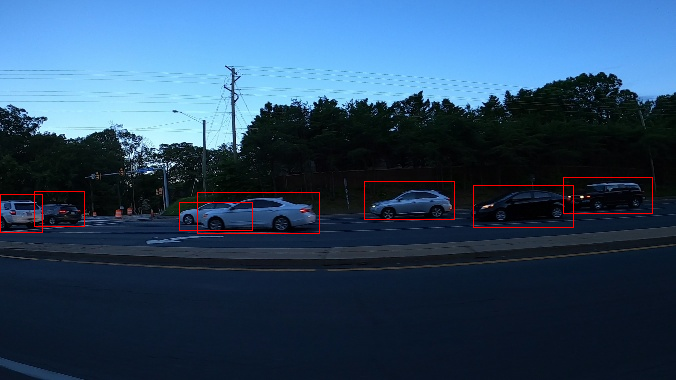

In [ ]:
show_img_and_bboxes_by_name(table, 'vid_4_26460.jpg') # vid_4_26460.jpg - 7 cars

Функции для отображения результатов обработки моделью YOLO

In [ ]:
def show_predict(model, table, i):
  """
      Функция принимает на вход модель YOLO, pd.DataFrame таблицу с данными
      по датасету и номер сэмпла из этого датасета.
      :return:
        cv2.Image pred[0].plot() - результат обработки моделью фотографии
  """
  image_name = table.iloc[i].image
  img = cv2.imread(filename=PATH + 'train/' + table.iloc[i].image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred = model.predict(img)
  bbox_coord = list(map(int, pred[0].boxes.xyxy[0]))
  return pred[0].plot()

Пример использования функции


0: 384x640 7 cars, 584.5ms
Speed: 11.8ms preprocess, 584.5ms inference, 34.3ms postprocess per image at shape (1, 3, 384, 640)


array([[[ 84, 147, 226],
        [ 84, 147, 226],
        [ 82, 148, 226],
        ...,
        [ 69, 131, 214],
        [ 71, 133, 216],
        [ 72, 134, 217]],

       [[ 84, 147, 226],
        [ 84, 147, 226],
        [ 82, 148, 226],
        ...,
        [ 72, 134, 217],
        [ 73, 135, 218],
        [ 73, 135, 218]],

       [[ 83, 149, 227],
        [ 83, 149, 227],
        [ 83, 149, 227],
        ...,
        [ 73, 135, 218],
        [ 73, 135, 218],
        [ 72, 134, 217]],

       ...,

       [[ 11,  20,  37],
        [ 12,  21,  38],
        [ 12,  21,  38],
        ...,
        [  8,  17,  32],
        [  8,  17,  32],
        [  8,  17,  32]],

       [[ 11,  19,  38],
        [ 11,  19,  38],
        [ 11,  19,  38],
        ...,
        [  8,  17,  32],
        [  8,  17,  32],
        [  8,  17,  32]],

       [[ 11,  19,  38],
        [ 11,  19,  38],
        [ 11,  19,  38],
        ...,
        [  8,  17,  32],
        [  8,  17,  32],
        [  8,  17,  32]]], dtype=uint8)
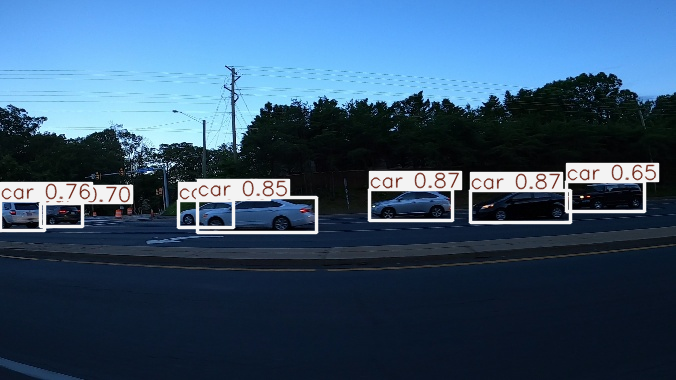

In [ ]:
show_predict(model, table, 336)

## Загрузка модели YOLO. Обучение

In [ ]:
model = YOLO('yolov8s.pt')

На официальном сайте советуется для начала брать 300 итераций обучения и брать больше объектов в батче. YOLOv8 автоматически аугментирует входящие изображения. Результаты последнего успешного обучения можно посмотреть в архиве train2.zip.

Файл 'dataset2.yaml', с помощью которого задаются опции обучения: количество классов, их названия и расположение датасетов, - находится в папке проекта

In [ ]:
model.train(data='dataset2.yaml', epochs=300, batch=32)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset2.yaml, epochs=300, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/drive/MyDrive/yolo_dataset/labels/train... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:04<00:00, 83.54it/s] 


train: New cache created: /content/drive/MyDrive/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/yolo_dataset/labels/train.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      8.13G      1.956      1.802      1.469         16        640: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559      0.913      0.914      0.943      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      8.01G      1.547     0.8215      1.265         10        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        355        559      0.973       0.97      0.989      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      8.05G      1.327     0.6185      1.105         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        355        559      0.977      0.972      0.988      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      8.01G      1.243     0.5422      1.068          2        640: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559      0.978      0.976      0.992      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      8.02G      1.176     0.5119      1.037          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        355        559      0.973      0.984      0.991       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      8.03G      1.165      0.498      1.027         15        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all        355        559      0.984      0.984      0.992       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      8.03G      1.153      0.485      1.034         13        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

                   all        355        559      0.977      0.991      0.994      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      8.07G      1.111     0.4737      1.008         13        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        355        559      0.987      0.981      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      8.03G      1.107     0.4699      1.021         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

                   all        355        559      0.986      0.993      0.994       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      8.06G      1.092     0.4654      1.014          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all        355        559      0.981      0.995      0.994      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      8.06G      1.067     0.4638      1.002          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

                   all        355        559      0.991      0.983      0.994      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      8.02G      1.052     0.4656     0.9966         17        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        355        559       0.99      0.993      0.994      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      8.02G      1.056     0.4531      1.003          3        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all        355        559      0.989      0.989      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      8.02G      1.025     0.4508      1.003         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

                   all        355        559      0.991      0.993      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      8.02G      1.028     0.4437      1.002         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559       0.99      0.993      0.994      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      8.02G      1.062     0.4541      1.003          8        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        355        559      0.989      0.994      0.995      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      8.02G          1     0.4408     0.9781         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all        355        559      0.991      0.993      0.994      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      8.03G      1.002     0.4273     0.9932         10        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559      0.995      0.988      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      8.03G      1.009     0.4483     0.9999         13        640: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559      0.992      0.986      0.993      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      8.02G     0.9729     0.4275     0.9824          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

                   all        355        559      0.995      0.989      0.994      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      8.03G     0.9769      0.429     0.9921         11        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559      0.996      0.992      0.994       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      8.02G     0.9548      0.423     0.9759         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

                   all        355        559      0.996      0.987      0.994      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      8.03G     0.9567     0.4302     0.9698         17        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all        355        559       0.99      0.993      0.994      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      8.07G     0.9503     0.4287     0.9534          5        640: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all        355        559      0.996      0.995      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      8.07G     0.9436     0.4191     0.9602         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]

                   all        355        559      0.991      0.989      0.995      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      8.02G     0.9534     0.4215     0.9617          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559      0.993      0.991      0.995       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      8.03G     0.9128     0.4124     0.9431         18        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        355        559      0.993      0.993      0.995      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      8.07G     0.8968     0.4122      0.944         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        355        559      0.991      0.998      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      8.03G     0.8863     0.3983     0.9473          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559      0.986      0.996      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      8.03G     0.8665     0.3954     0.9463         10        640: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

                   all        355        559       0.99      0.996      0.995      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      8.02G     0.8619     0.3879     0.9305         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559      0.996      0.994      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      8.02G     0.8691      0.392      0.946          8        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559      0.998      0.993      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      8.07G     0.8373     0.3865     0.9313         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        355        559          1      0.993      0.995      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      8.03G     0.8451      0.379     0.9292          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559      0.995      0.993      0.995      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      8.03G     0.8377     0.3878     0.9192         10        640: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        355        559      0.998      0.993      0.995      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      8.07G     0.8566     0.3865     0.9458          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        355        559      0.998      0.994      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      8.02G     0.8135     0.3751     0.9335          6        640: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559      0.998      0.995      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      8.02G     0.8604      0.397     0.9347          6        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        355        559      0.995      0.998      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      8.06G     0.8226     0.3759     0.9278         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        355        559      0.996      0.996      0.995      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      8.02G      0.805     0.3717     0.9216          6        640: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559      0.995      0.998      0.995      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      8.07G     0.7799     0.3735     0.9122          4        640: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        355        559      0.998      0.994      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      8.02G     0.7731     0.3584     0.9104          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        355        559      0.996      0.993      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      8.03G     0.7856     0.3711      0.908          8        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        355        559      0.993      0.996      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      8.02G     0.7185      0.352     0.9001          6        640: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        355        559      0.995      0.998      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      8.03G     0.7731     0.3712     0.9092         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all        355        559      0.996      0.998      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      8.07G     0.7732     0.3683     0.9222          4        640: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559      0.994          1      0.995      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      8.02G     0.7779     0.3648     0.9109         11        640: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        355        559      0.996      0.997      0.995      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      8.06G     0.7275     0.3465     0.8973          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

                   all        355        559      0.995      0.998      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      8.03G     0.7391     0.3499     0.9054         18        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559      0.993      0.998      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      8.06G     0.6998     0.3364     0.8858          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

                   all        355        559      0.998      0.996      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      8.11G     0.7143     0.3458      0.889          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        355        559      0.996      0.998      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      8.07G     0.7369     0.3459      0.906          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        355        559      0.998      0.998      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      8.02G     0.7195     0.3541     0.9032         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        355        559      0.998          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      8.06G     0.7123     0.3506     0.8928          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        355        559      0.994          1      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      8.06G     0.6963     0.3373     0.8849          7        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        355        559      0.998      0.998      0.995      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      8.07G     0.6818     0.3386     0.8854         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        355        559          1          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      8.02G     0.7242     0.3441     0.9204          8        640: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        355        559      0.995          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      8.06G     0.7016     0.3581     0.8819          6        640: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

                   all        355        559      0.998          1      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      8.03G     0.7088     0.3488     0.8956          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]

                   all        355        559      0.998          1      0.995      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      8.02G     0.6932     0.3395     0.8886          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all        355        559      0.998          1      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      8.02G     0.6353      0.351     0.8763          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

                   all        355        559      0.998          1      0.995      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      8.02G     0.6375     0.3179     0.8675          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559      0.998          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      8.02G     0.6483     0.3283      0.867         15        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all        355        559      0.997          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      8.07G     0.6274     0.3188     0.8652          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]

                   all        355        559          1          1      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      8.06G     0.6093     0.3106     0.8654          4        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        355        559          1          1      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      8.03G      0.635     0.3264     0.8607         11        640: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        355        559          1          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      8.03G      0.623     0.3158     0.8637         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        355        559          1          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      8.07G     0.6431     0.3334     0.8756         12        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

                   all        355        559          1          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      8.03G     0.6279     0.3122     0.8748         11        640: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        355        559          1          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      8.03G     0.6157     0.3152     0.8794          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]

                   all        355        559          1          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      8.02G     0.6015     0.3204     0.8663          5        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        355        559          1          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      8.03G      0.635     0.3181     0.8679         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        355        559          1          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      8.07G     0.5981     0.3061     0.8667          8        640: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559      0.998          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      8.02G     0.6048     0.3174     0.8645          4        640: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.11s/it]

                   all        355        559          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      8.03G     0.5949     0.3159     0.8742          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

                   all        355        559      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      8.03G     0.5804     0.3068     0.8645          4        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      8.03G     0.5925     0.3055     0.8625         11        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

                   all        355        559      0.999          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      8.08G     0.5725     0.3027     0.8527          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        355        559      0.996          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      8.03G     0.5979     0.3087     0.8667         14        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        355        559          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      8.08G     0.5874     0.3053     0.8591         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        355        559          1          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      8.07G     0.6073     0.3118     0.8621          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      8.03G     0.6043     0.3098     0.8722         11        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        355        559          1          1      0.995      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      8.02G     0.5434     0.2929     0.8446          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        355        559          1          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      8.03G     0.5785     0.3021     0.8444         17        640: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      8.07G     0.5929     0.3052     0.8692          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]

                   all        355        559          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      8.02G     0.6139     0.3158     0.8799          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

                   all        355        559      0.999          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      8.07G     0.5651     0.3078     0.8617          3        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559      0.999          1      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      8.03G      0.578      0.306     0.8483         15        640: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        355        559          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      8.06G     0.5781     0.3125     0.8583          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all        355        559          1          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      8.02G     0.5644     0.2991     0.8548          5        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        355        559          1          1      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      8.03G      0.562     0.3017     0.8533         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]

                   all        355        559          1          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      8.07G      0.562     0.2995     0.8643          3        640: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        355        559          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      8.03G     0.5316     0.2838     0.8601         15        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        355        559          1          1      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      8.07G     0.5303     0.2834     0.8518         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all        355        559          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      8.02G      0.545     0.2919     0.8547          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all        355        559          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      8.03G     0.5209     0.2831     0.8415          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

                   all        355        559          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      8.07G     0.5125     0.2815     0.8347          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all        355        559          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      8.02G     0.5302     0.2818      0.846          8        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        355        559          1          1      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      8.03G     0.5155     0.2837     0.8439          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]

                   all        355        559          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      8.03G     0.5566     0.2951     0.8624          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        355        559          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      8.07G     0.5212     0.2839     0.8449          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

                   all        355        559          1          1      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      8.02G     0.5144     0.2834     0.8464          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        355        559          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      8.07G     0.5091     0.2785     0.8456         13        640: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      8.06G     0.5106     0.2844     0.8421         10        640: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]

                   all        355        559          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      8.07G     0.5101     0.2771     0.8358         18        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        355        559          1      0.998      0.995      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      8.07G     0.5195     0.2839     0.8512          7        640: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      8.07G      0.534     0.2894     0.8506          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559      0.999      0.998      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      8.03G     0.5295     0.2871     0.8516          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all        355        559      0.998          1      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      8.07G     0.5076     0.2823     0.8327         16        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

                   all        355        559      0.998          1      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      8.06G     0.5057     0.2798     0.8299          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        355        559          1      0.999      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      8.07G     0.4965     0.2703     0.8389          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all        355        559          1          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      8.03G     0.4794     0.2708     0.8398          6        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        355        559          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      8.07G     0.4993     0.2796     0.8551         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        355        559          1          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      8.02G      0.505     0.2772     0.8396         11        640: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559          1          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      8.02G     0.4881      0.281     0.8392          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        355        559          1          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      8.03G     0.5064     0.2823      0.837         15        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

                   all        355        559          1          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      8.07G     0.4882     0.2702     0.8448          5        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

                   all        355        559          1          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      8.03G     0.4884     0.2719     0.8316         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.22s/it]

                   all        355        559          1          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      8.06G     0.5038     0.2863     0.8604          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]

                   all        355        559          1          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      8.03G      0.466     0.2667     0.8324          4        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]

                   all        355        559          1          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      8.07G     0.4771      0.271     0.8407          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all        355        559          1          1      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      8.03G     0.4776     0.2709     0.8391         13        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559      0.998          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      8.02G     0.5088     0.2811      0.837          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

                   all        355        559      0.998          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      8.03G     0.4702     0.2687     0.8413          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559      0.998          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      8.02G     0.4565     0.2661     0.8292          4        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        355        559      0.997          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      8.03G      0.458     0.2602     0.8318         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

                   all        355        559          1          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      8.02G     0.4559     0.2627     0.8268          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

                   all        355        559      0.998          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      8.03G     0.4508     0.2639     0.8333          8        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        355        559      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      8.03G     0.4529       0.26     0.8291          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all        355        559      0.998          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      8.07G     0.4748     0.2829     0.8497         10        640: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559      0.998          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      8.07G     0.4725     0.2707     0.8291         20        640: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        355        559      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      8.07G     0.4373      0.263      0.822          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

                   all        355        559      0.998          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      8.02G     0.4493      0.261     0.8344          9        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      8.07G     0.4458     0.2609     0.8198         12        640: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        355        559          1          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      8.07G     0.4444      0.264     0.8223         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        355        559          1          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      8.03G     0.4456      0.258     0.8287          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559          1          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      8.03G     0.4368     0.2578     0.8271         18        640: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]

                   all        355        559          1      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      8.06G     0.4502     0.2736     0.8334          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]

                   all        355        559      0.998          1      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      8.02G     0.4619     0.2693     0.8345          6        640: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all        355        559      0.998          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      8.08G     0.4538     0.2747     0.8249          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        355        559      0.998          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      8.03G     0.4468     0.2577     0.8237         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        355        559      0.998          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      8.07G     0.4695     0.2683     0.8407         10        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        355        559      0.999          1      0.995      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      8.03G     0.4427     0.2563     0.8276          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

                   all        355        559      0.999          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      8.07G     0.4872     0.2773     0.8576          2        640: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559      0.999          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      8.06G     0.4449     0.2604     0.8301          4        640: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        355        559          1          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      8.02G     0.4584     0.2733     0.8245         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        355        559          1          1      0.995      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      8.03G     0.4527     0.2623     0.8312         14        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

                   all        355        559          1          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      8.07G     0.4255     0.2502     0.8379          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

                   all        355        559          1          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      8.07G     0.4561      0.256     0.8212         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        355        559          1          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      8.07G       0.43     0.2523     0.8179         14        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        355        559          1          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      8.03G     0.4293     0.2529     0.8363          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        355        559          1          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      8.03G     0.4396     0.2496     0.8306          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      8.02G     0.4286     0.2539     0.8133          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

                   all        355        559          1          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      8.02G     0.4197     0.2497     0.8149          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        355        559          1      0.999      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      8.03G     0.4342     0.2447     0.8299          6        640: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1      0.999      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      8.03G     0.4012     0.2431     0.8207         13        640: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

                   all        355        559          1          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      8.03G     0.4173     0.2504     0.8152         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

                   all        355        559          1          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      8.03G     0.4148     0.2498     0.8311          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      8.03G     0.4084     0.2426     0.8098          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

                   all        355        559          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      8.03G     0.3966     0.2472      0.812          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        355        559          1          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      8.02G     0.4153     0.2498     0.8293          6        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all        355        559          1          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      8.02G     0.4341     0.2542     0.8377         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all        355        559      0.999          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      8.03G     0.4258     0.2637     0.8227         11        640: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559      0.999          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      8.03G     0.4365     0.2597     0.8237         13        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

                   all        355        559          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      8.08G     0.4435     0.2537      0.851          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        355        559          1          1      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      8.07G     0.3967     0.2413     0.8224         15        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        355        559          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      8.03G     0.4091     0.2391     0.8326          2        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]

                   all        355        559          1          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      8.03G     0.4591     0.2623     0.8411         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.20it/s]

                   all        355        559          1          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      8.06G     0.4148      0.246     0.8175          7        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559          1          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      8.03G     0.3951     0.2355     0.8163         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559          1          1      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      8.07G     0.4007     0.2402     0.8197          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all        355        559          1          1      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      8.02G     0.4086     0.2422     0.8101          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      8.07G     0.4078     0.2413     0.8208          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      8.07G     0.3933     0.2391     0.8205          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        355        559          1          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      8.03G     0.4051     0.2437     0.8102         13        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        355        559          1          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      8.03G     0.4011     0.2451     0.8205         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        355        559          1          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      8.03G     0.4128     0.2552     0.8233          9        640: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      8.07G     0.4176     0.2506     0.8173         15        640: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      8.02G     0.3856     0.2314     0.8226         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      8.03G     0.4063     0.2391     0.8209          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        355        559          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      8.03G     0.3964     0.2379     0.8158          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

                   all        355        559          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      8.07G     0.3943     0.2386     0.8138         17        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

                   all        355        559          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      8.03G     0.3892     0.2368     0.8086         12        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      8.03G     0.3778     0.2354     0.8092         16        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        355        559          1          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      8.02G     0.3861     0.2476     0.8215          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      8.11G      0.381      0.232     0.8116          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all        355        559          1          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      8.07G      0.374     0.2328     0.8115          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

                   all        355        559          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      8.07G     0.3737     0.2316     0.8078          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      8.03G     0.3839     0.2367     0.8136         12        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      8.07G     0.3854     0.2357     0.8098         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      8.02G     0.3812     0.2285     0.8181          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      8.03G     0.3771     0.2266       0.81         10        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559          1          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      8.07G     0.3677     0.2177     0.8096          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.20it/s]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      8.02G      0.387     0.2316     0.8202          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      8.02G     0.3818     0.2418     0.8087          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      8.07G     0.3778     0.2264     0.8093          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      8.02G     0.3709     0.2268     0.8063          7        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      8.07G     0.3733     0.2239     0.8265         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

                   all        355        559          1          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      8.07G     0.3677     0.2244     0.8126          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      8.03G     0.3921     0.2386     0.8192         13        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      8.03G     0.3889     0.2386      0.824         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]

                   all        355        559          1          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      8.03G     0.3811     0.2368     0.8094          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      8.07G     0.3755      0.229      0.818         10        640: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        355        559      0.999          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      8.06G     0.3562      0.224     0.7996          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

                   all        355        559          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      8.02G     0.3642      0.225     0.8064          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]

                   all        355        559          1          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      8.03G     0.3642     0.2283     0.8117         10        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

                   all        355        559          1          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      8.08G     0.3688     0.2258     0.8214         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      8.07G     0.3936     0.2413     0.8222         15        640: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        355        559          1          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      8.03G     0.3711     0.2191     0.8109          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]

                   all        355        559          1          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      8.03G      0.394     0.2388     0.8288          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

                   all        355        559          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      8.07G     0.3679     0.2231     0.8163          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

                   all        355        559          1          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      8.07G     0.3572     0.2242      0.812          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.17s/it]

                   all        355        559          1          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      8.06G     0.3546     0.2203      0.805          7        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      8.02G     0.3852     0.2257     0.8146          7        640: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.06s/it]

                   all        355        559          1          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      8.03G     0.3552     0.2185     0.8156         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      8.06G     0.3621     0.2254     0.8024          7        640: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      8.03G      0.363     0.2203     0.8047          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      8.03G     0.3566     0.2214      0.809          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      8.03G     0.3716     0.2297     0.8147         12        640: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      8.07G     0.3651      0.227     0.8115         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.21s/it]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      8.07G     0.3405     0.2184     0.8093          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      8.07G     0.3444     0.2214     0.8051          9        640: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]

                   all        355        559          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      8.02G     0.3516     0.2212     0.8091          2        640: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      8.07G     0.3643     0.2246     0.8147         10        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      8.02G     0.3663     0.2251     0.8145          7        640: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.20s/it]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      8.03G     0.3654     0.2324     0.8119         15        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      8.03G      0.377     0.2311     0.8159         10        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      8.03G     0.3464     0.2277     0.8127         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      8.02G     0.3751     0.2263     0.8257          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      8.03G     0.3466     0.2216     0.8177          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

                   all        355        559          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      8.03G     0.3493     0.2143     0.8043          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      8.03G     0.3427     0.2151     0.8194          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      8.07G      0.354     0.2189     0.8156         11        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      8.02G     0.3457     0.2205     0.8107          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      8.02G     0.3448     0.2178     0.8121         13        640: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      8.03G     0.3594     0.2206     0.8177          7        640: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      8.03G     0.3383     0.2145     0.8077          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      8.02G     0.3567     0.2184     0.8179          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      8.02G      0.344     0.2153     0.8091         12        640: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      8.03G     0.3724     0.2244     0.8164          9        640: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      8.02G     0.3494     0.2229     0.8138          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      8.02G     0.3401     0.2272     0.8221          1        640: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      8.06G     0.3477      0.217     0.8185          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      8.03G     0.3343     0.2132     0.8043          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      8.08G     0.3465     0.2177     0.8138         11        640: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      8.07G     0.3454     0.2245     0.8146          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      8.07G     0.3485     0.2229     0.8168          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.13s/it]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      8.03G      0.357     0.2337      0.811          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      8.07G     0.3326     0.2092     0.8021          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      8.02G     0.3407      0.226     0.7998          3        640: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      8.08G     0.3337     0.2155     0.7991          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.30it/s]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      8.07G     0.3199     0.2122     0.7983          9        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      8.06G     0.3361     0.2096     0.8091          5        640: 100%|██████████| 12/12 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      8.02G     0.3169     0.2007     0.8134          5        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      8.03G     0.3286     0.2105     0.8068          8        640: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      8.07G      0.324     0.2063      0.806          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]

                   all        355        559          1          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      8.06G     0.3355     0.2101     0.8068         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      8.02G      0.317     0.2035     0.8092          6        640: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      8.07G     0.3453      0.217     0.8073         12        640: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      8.02G     0.3444     0.2169     0.8099         16        640: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      8.07G     0.3318     0.2062      0.812          5        640: 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      8.08G     0.3484     0.2266     0.8048          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      8.06G     0.3469     0.2185     0.8171          7        640: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      8.03G     0.3396     0.2123     0.8095          8        640: 100%|██████████| 12/12 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      8.03G     0.3288     0.2079     0.8034         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      8.08G     0.3172      0.205      0.804          5        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      8.02G     0.3262     0.2071     0.8074          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      8.02G     0.3294     0.2074     0.8005          8        640: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all        355        559          1          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      8.03G     0.3261     0.2053     0.8064         14        640: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      8.07G     0.3181     0.2035     0.8078         10        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      8.07G     0.3204     0.2057     0.8046         13        640: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      8.03G     0.3339     0.2076     0.8109          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      8.02G     0.3208     0.2037     0.7984          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      8.03G     0.3253     0.2098     0.8133         10        640: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      8.03G     0.3284     0.2096     0.8122          4        640: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      8.08G     0.3091     0.2045     0.8082          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      8.06G     0.3371     0.2075     0.8095         11        640: 100%|██████████| 12/12 [00:08<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

                   all        355        559          1          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      8.02G     0.3828     0.2189     0.8245          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      8.03G     0.3065     0.1992     0.7988          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      8.03G     0.3303     0.2143     0.8125          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      8.02G     0.3155     0.1976     0.8081          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      8.03G     0.3043     0.1952     0.8023         14        640: 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      8.07G     0.3293     0.2051     0.8117          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      8.03G      0.325     0.2097     0.8065         14        640: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      8.03G     0.3167     0.2005      0.815          8        640: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      8.07G     0.3288     0.2026     0.8057          8        640: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      8.03G     0.3093     0.2025     0.8058          5        640: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      8.03G     0.3305     0.2107     0.8078          9        640: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.35s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      8.02G      0.321     0.2082     0.8062          7        640: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      8.07G     0.3375     0.2183      0.823          4        640: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

                   all        355        559          1          1      0.995      0.989


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      8.03G     0.3834     0.2111     0.8006          4        640: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        355        559          1          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      8.02G     0.4037     0.2229     0.8183          4        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]

                   all        355        559          1          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      8.02G     0.3502     0.2017     0.7942          3        640: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]

                   all        355        559          1          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      8.02G     0.3305     0.2019     0.7967          6        640: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]

                   all        355        559          1          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      8.02G     0.3437     0.2005     0.7922          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      8.02G     0.3159     0.1939     0.8021          2        640: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]

                   all        355        559          1          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      8.02G      0.387     0.2151     0.8171          3        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

                   all        355        559          1          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      8.02G     0.3145     0.1886     0.7969          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

                   all        355        559          1          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      8.02G     0.3234     0.1949     0.7895          3        640: 100%|██████████| 12/12 [00:08<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        355        559          1          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      8.03G     0.3192     0.1931     0.7953          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]

                   all        355        559          1          1      0.995       0.98



300 epochs completed in 1.219 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


                   all        355        559          1          1      0.995       0.99
                   car        355        559          1          1      0.995       0.99
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c20031188e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Результаты валидации (принимать их во внимание сложно, т.к. валидационная и тренировочная выборки не были разделены. Скорее всего, наблюдается сценарий с переобучением)

In [ ]:
res = model.val(data='dataset2.yaml')

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning /content/drive/MyDrive/yolo_dataset/labels/train.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


                   all        355        559          1          1      0.995       0.99
                   car        355        559          1          1      0.995       0.99
Speed: 0.2ms preprocess, 7.4ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train22


In [ ]:
res.results_dict

{'metrics/precision(B)': 0.0,
 'metrics/recall(B)': 0.0,
 'metrics/mAP50(B)': 0.0,
 'metrics/mAP50-95(B)': 0.0,
 'fitness': 0.0}

Сравнение результатов моделей до обучения и после

In [ ]:
model_pre = YOLO('yolov8s.pt').to(device)

Результаты модели до обучения

In [ ]:
model_pre.val(data='dataset2.yaml')

YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


val: Scanning /content/drive/MyDrive/yolo_dataset/labels/train.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


                   all        355        559      0.886      0.874      0.909      0.319
                   car        355        559      0.886      0.874      0.909      0.319
Speed: 0.3ms preprocess, 6.9ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c2003344040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Как мы можем заметить, точность во всех основных метриках повысилась по результатам обучения на соответствующей выборке.


0: 384x640 4 cars, 12.3ms
Speed: 3.2ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


array([[[212, 254, 252],
        [212, 254, 252],
        [212, 254, 252],
        ...,
        [194, 240, 253],
        [194, 240, 253],
        [195, 241, 254]],

       [[212, 254, 252],
        [212, 254, 252],
        [212, 254, 252],
        ...,
        [194, 240, 253],
        [195, 241, 254],
        [195, 241, 254]],

       [[213, 253, 252],
        [213, 253, 252],
        [213, 253, 252],
        ...,
        [195, 241, 254],
        [195, 241, 254],
        [195, 241, 254]],

       ...,

       [[154, 185, 206],
        [152, 183, 204],
        [156, 187, 208],
        ...,
        [138, 173, 195],
        [138, 173, 195],
        [139, 174, 196]],

       [[156, 188, 211],
        [152, 184, 205],
        [153, 185, 206],
        ...,
        [131, 163, 186],
        [133, 165, 188],
        [135, 167, 190]],

       [[151, 183, 206],
        [153, 185, 208],
        [156, 188, 209],
        ...,
        [124, 156, 179],
        [126, 158, 181],
        [128, 160, 183]]], dtype=uint8)
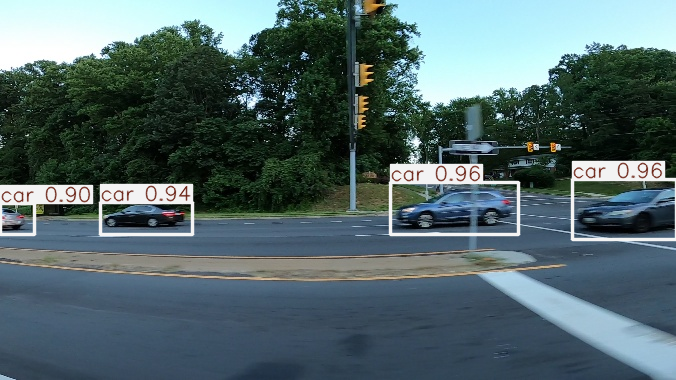

In [ ]:
show_predict(model, table, 225)

## Рекомендации к повышению точности



1.   **Выбор более большой pre-trained модели из списка**:

```
yolov8m.pt, yolov8l.pt, yolov8x.pt
```
Минус использования бОльших моделей --- уменьшение скорости работы веб-сервиса, а именно, большее время отклика сервера. По этой причине была выбрана модель под индексом s (small). Будучи fine-tuned на прилагаемом датасете, выдает хорошие результаты при меньших ресурсах времени.


2.   **Увеличение выборки, привлечение сторонних данных**

3. **Обучение модели лишь на одном классе**:

Перспективен подход с игнорированием всех предыдущих 80 классов кроме одного - класса *'car'*. Однако, как показала практика, результаты работы модели сильно хуже результатов обработки оригинальными моделями YOLO. Вероятно, необходимо увеличить размер выборки.

В данном проекте модель обучалась со всеми 80ью классами, но в выборке присутствовали лишь объекты класса 'car'. Результаты оказались намного лучше описанного выше подхода.



